In [1]:
import numpy as np 
import collections
from collections import defaultdict
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from skimage.io import imread
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Remove warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/adejuwon/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**LOAD DATASET

In [27]:
all_scans_df = pd.DataFrame(dict(path = glob(os.path.join('MURA-v1.1', '*', '*', '*', '*', '*.png'))))
all_scans_df['TrainSplit'] = all_scans_df['path'].map(lambda x: x.split('/')[-5])
all_scans_df['Region'] = all_scans_df['path'].map(lambda x: x.split('/')[2])
all_scans_df['Patient'] = all_scans_df['path'].map(lambda x: x.split('/')[-3])
all_scans_df['FolderId'] = all_scans_df['path'].map(lambda x: x.split('/')[-2])
all_scans_df['Study'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[0])
all_scans_df['Labels'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[-1] )
all_scans_df.sample(20)

,path,TrainSplit,Region,Patient,FolderId,Study,Labels
26292,MURA-v1.1/train/XR_SHOULDER/patient01412/study...,train,XR_SHOULDER,patient01412,study1_positive,study1,positive
2917,MURA-v1.1/valid/XR_FOREARM/patient11488/study1...,valid,XR_FOREARM,patient11488,study1_negative,study1,negative
9302,MURA-v1.1/train/XR_HUMERUS/patient02906/study1...,train,XR_HUMERUS,patient02906,study1_positive,study1,positive
6168,MURA-v1.1/train/XR_HAND/patient00483/study1_ne...,train,XR_HAND,patient00483,study1_negative,study1,negative
36390,MURA-v1.1/train/XR_WRIST/patient06473/study1_p...,train,XR_WRIST,patient06473,study1_positive,study1,positive
9248,MURA-v1.1/train/XR_HUMERUS/patient03076/study1...,train,XR_HUMERUS,patient03076,study1_negative,study1,negative
27070,MURA-v1.1/train/XR_SHOULDER/patient01431/study...,train,XR_SHOULDER,patient01431,study1_negative,study1,negative
36138,MURA-v1.1/train/XR_WRIST/patient07751/study1_n...,train,XR_WRIST,patient07751,study1_negative,study1,negative
15094,MURA-v1.1/train/XR_FINGER/patient04659/study1_...,train,XR_FINGER,patient04659,study1_negative,study1,negative
8432,MURA-v1.1/train/XR_HAND/patient09744/study1_po...,train,XR_HAND,patient09744,study1_positive,study1,positive


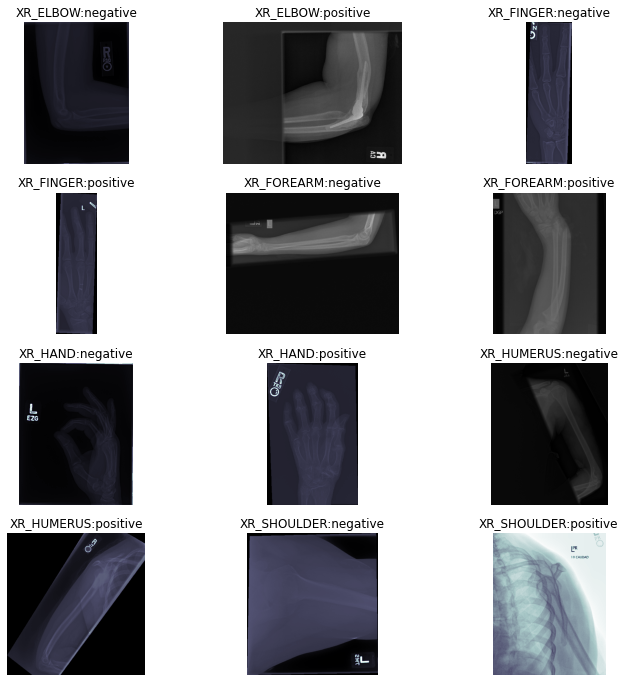

In [150]:
sub_df = all_scans_df.groupby(['Region', 'Labels']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Region}:{Labels}'.format(**c_row))
fig.savefig('samples.png', dpi = 300)

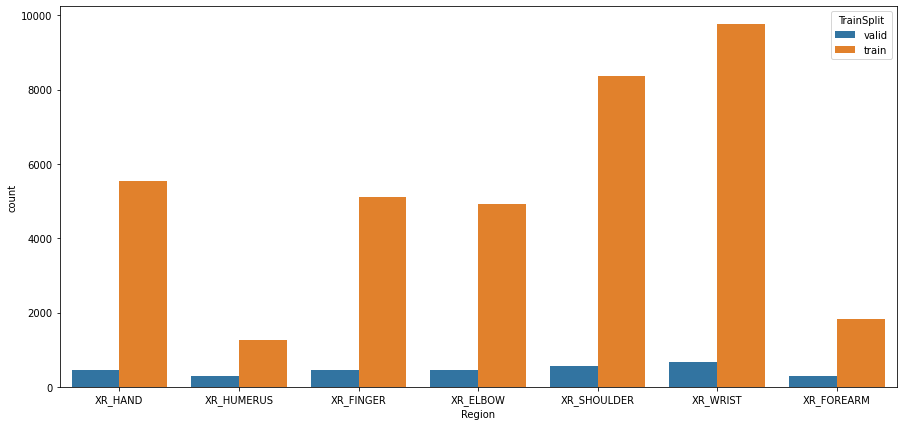

In [3]:
plt.figure(figsize=(15,7))
sns.countplot(data=all_scans_df,x='Region',hue='TrainSplit')

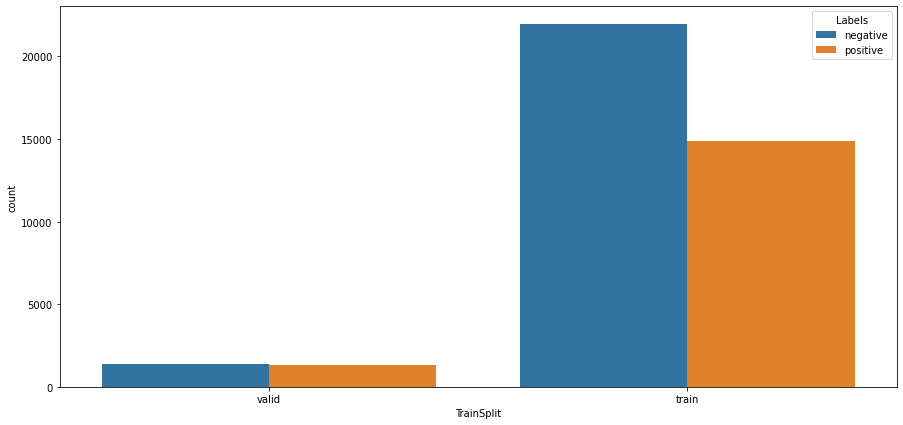

In [103]:
plt.figure(figsize=(15,7))
sns.countplot(data=all_scans_df,x='TrainSplit',hue='Labels')

For only Training Labels study type

In [5]:
data_cat= ['train', 'valid']
Body_Part = list(os.walk('/Users/adejuwon/MURA-v1.1/train/'))[0][1] # study types, same for train and valid sets

patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in Body_Part:
        patients = list(os.walk('/Users/adejuwon/MURA-v1.1/%s/%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

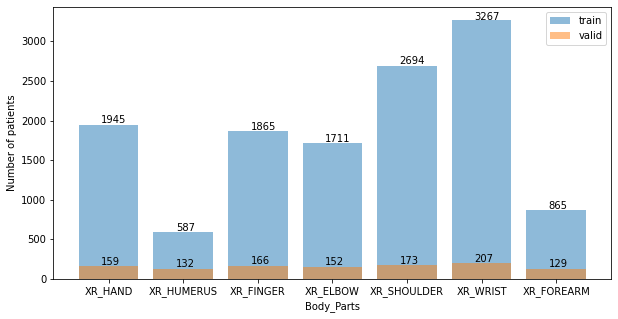

In [6]:
# plot the patient counts per study type 

fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(Body_Part))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, Body_Part)

plt.xlabel('Body_Parts')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()



In [146]:
# let's find out number of studies per study_type
study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR ='/Users/adejuwon/MURA-v1.1/train/%s/'  % study_type
    study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        study_count[study_type][len(studies)] += 1


In [179]:
study_count

{'XR_HAND': defaultdict(<function __main__.<lambda>()>, {2: 2, 1: 1}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>, {1: 128, 2: 4}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>,
             {2: 8, 1: 157, 3: 1}),
 'XR_ELBOW': defaultdict(<function __main__.<lambda>()>, {1: 144, 2: 8}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>,
             {1: 155, 2: 15, 3: 3}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>,
             {1: 181, 2: 22, 3: 3, 5: 1}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>,
             {1: 126, 3: 1, 2: 2})}

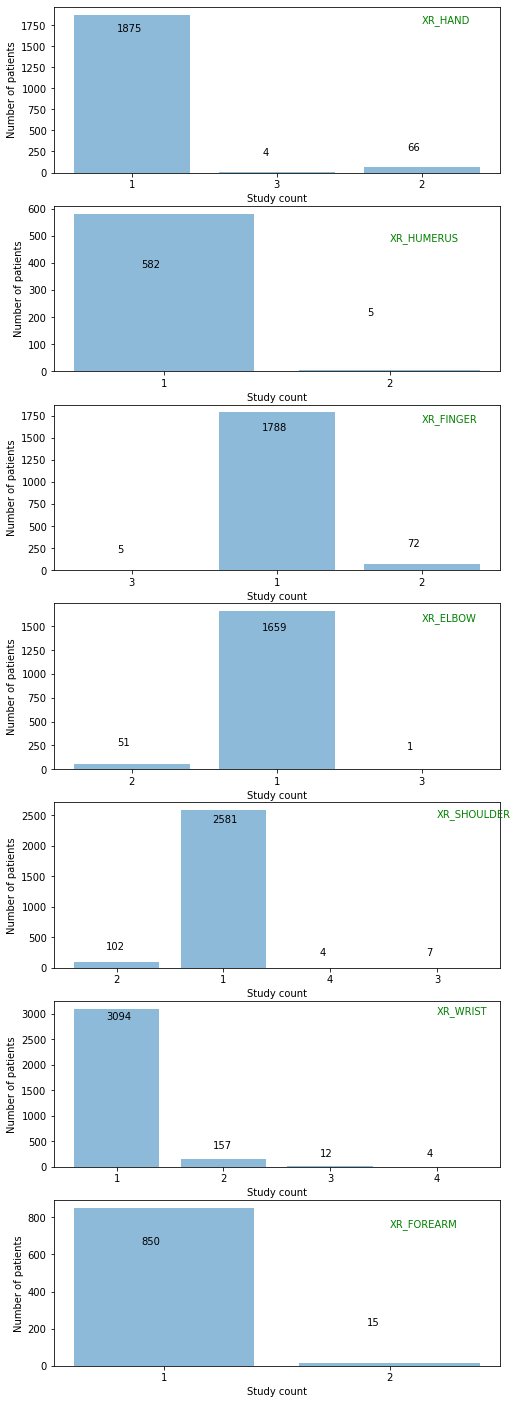

In [147]:
# plot the study count vs number of patients per study type data 
fig = plt.figure(figsize=(8, 25))
for i, study_type in enumerate(study_count):
    ax = fig.add_subplot(7, 1, i+1)
    study = study_count[study_type]
    # text in the plot
    m = max(study.values())
    for i, v in enumerate(study.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 200, str(v))
    ax.text(i, m - 100, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(study))
    plt.bar(x_pos, study.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  study.keys())
    plt.xlabel('Study count')
    plt.ylabel('Number of patients')
plt.show()

**Sorting data out into positive and negative for Training Data ( Normal and Abnormal Xrays) :Positive = 0 and Negative =1

In [108]:
PATH="MURA-v1.1/"

In [109]:
train_imgs_path=pd.read_csv(PATH+'train_image_paths.csv')
train_labels=pd.read_csv(PATH+'train_labeled_studies.csv')
valid_imgs_path=pd.read_csv(PATH+'valid_image_paths.csv')
valid_labels=pd.read_csv(PATH+'valid_labeled_studies.csv')

In [110]:
train_labels['Body_Part']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study_Type']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])
valid_labels['Body_Part']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
valid_labels['Study_Type']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])

In [151]:
train_labels['Label'].value_counts()

0    8280
1    5177
Name: Label, dtype: int64

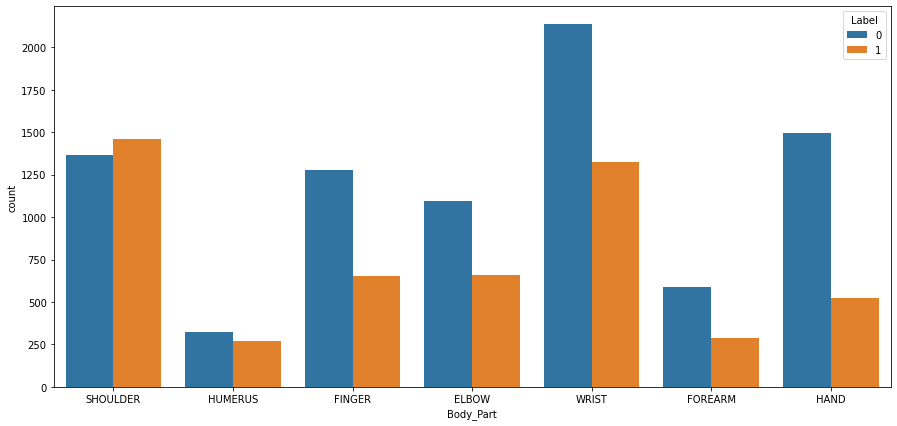

In [152]:
plt.figure(figsize=(15,7))
sns.countplot(data=train_labels,x='Body_Part',hue='Label')

**Sorting data out into positive and negative for Validation Data ( Normal and Abnormal Xrays) :Positive = 0 and Negative =1

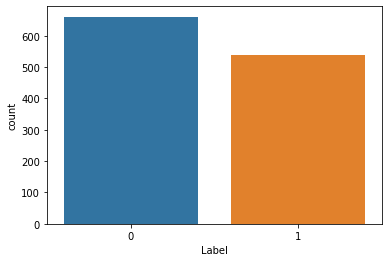

In [155]:
sns.countplot(valid_labels['Label'])

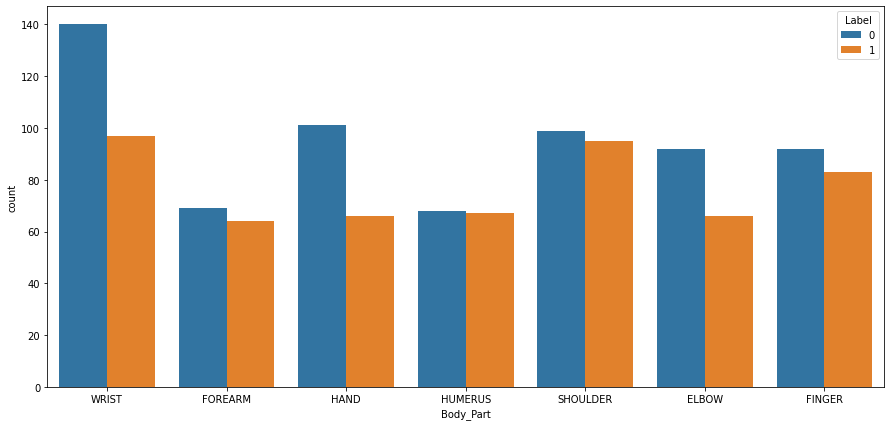

In [156]:
plt.figure(figsize=(15,7))
sns.countplot(data=valid_labels,x='Body_Part',hue='Label')

Sample of Images

In [11]:

PATH="MURA-v1.1/"

In [12]:
train_imgs_path=pd.read_csv(PATH+'train_image_paths.csv')
train_labels=pd.read_csv(PATH+'train_labeled_studies.csv')
valid_imgs_path=pd.read_csv(PATH+'valid_image_paths.csv')
valid_labels=pd.read_csv(PATH+'valid_labeled_studies.csv')

In [13]:
train_imgs_path.head()

,Img_Path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [14]:

train_imgs_path.shape

(36808, 1)

In [15]:
valid_labels.head()

,Img_Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [16]:

train_labels.head()

,Img_Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [18]:

valid_imgs_path.head()

,Image_Path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [19]:
valid_imgs_path.shape

(3197, 1)

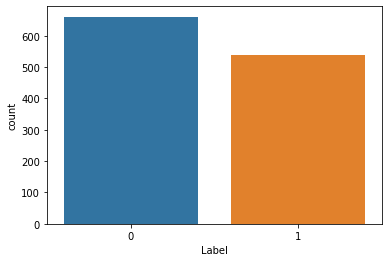

In [153]:
sns.countplot(valid_labels['Label'])

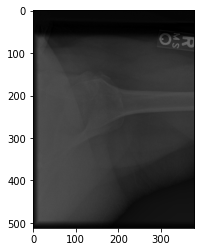

(512, 380, 3)


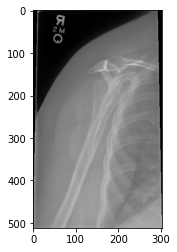

(512, 303, 3)


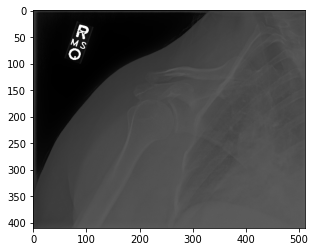

(410, 512, 3)


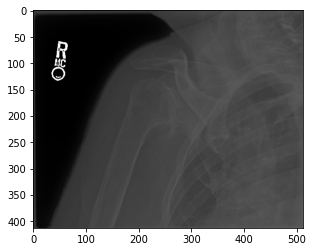

(413, 512, 3)


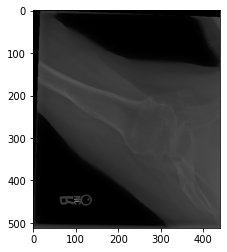

(512, 440, 3)


In [70]:
for path in train_imgs_path.values[:5]:
    img=cv2.imread(path[0])
    plt.imshow(plt.imread(path[0]))
    plt.imshow(img)
    plt.show()
    print (img.shape)

In [71]:

train_labels['Body_Part']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study_Type']=train_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])
valid_labels['Body_Part']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[2])[3:])
valid_labels['Study_Type']=valid_labels['Img_Path'].apply(lambda x: str(x.split('/')[4])[:6])

In [72]:
train_labels.head()

,Img_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,SHOULDER,study1


In [74]:
valid_labels.head()

,Img_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,study1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1,WRIST,study2
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1,WRIST,study3
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1,WRIST,study1


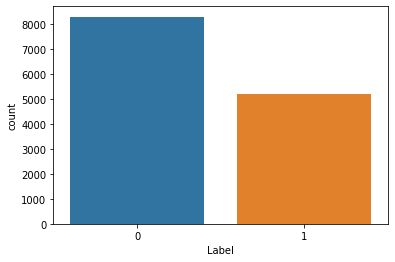

In [76]:
sns.countplot(train_labels['Label'])

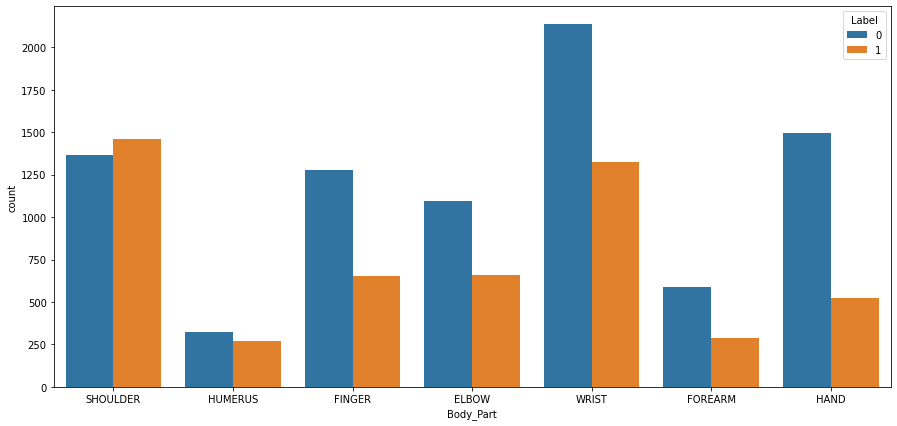

In [77]:
plt.figure(figsize=(15,7))
sns.countplot(data=train_labels,x='Body_Part',hue='Label')

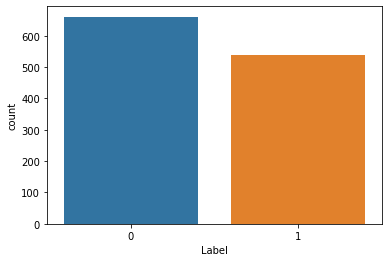

In [79]:
sns.countplot(valid_labels['Label'])


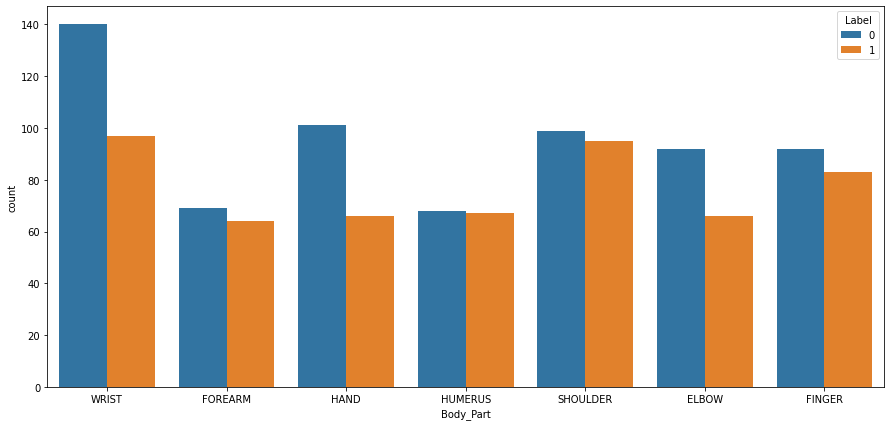

In [81]:
plt.figure(figsize=(15,7))
sns.countplot(data=valid_labels,x='Body_Part',hue='Label')